We want to do a book recommendation system based on the data we have cleaned before.
They are three types of recommender system:
* Collaborative filtering:This system matches persons with similar interests and provides recommendations based on this matching. It needs the historical activity of the users which we have.It can be user-based or item-based. In the first, we recommend items to a user that similar users have also liked. In the second, we recommend items based on the past ratings of similiar items by the user.

* Content base systems: They suggest similar items based on a particular item. This system uses item metadata. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it. The only metadata we have about the books in our dataset is the title, author and country wich is very little. A good metadata is the genres or the summary that sadly we haven't. This method is also computationally expensive which is another reason we are not doing it.

This system recommendation were mainly done with the helf of the book "Hands on recommendation systems with Python" by Rounak Banik 
https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/5f1269b2-2007-42a8-a900-bf255b86e64c.xhtml


We want to predict the rating given by a user to a book based on the book that he has already read and the books of user that have like the same books i.e similar users

# Loading the data previously cleaned

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
path="D:/Workspace_Python/MLProject/MachineLearningDSTIProject/dataset/"
file="final_dataset.csv"
users_csv="cleaned_users.csv"
books_csv="cleaned_books.csv"
ratings_csv="cleaned_ratings.csv"

# Recommender system

In [5]:
books = pd.read_csv(path+books_csv, sep=";",on_bad_lines='warn', encoding="latin-1")
books.bookId.max()

248251

## Choice of the algorithm

We load the data into the data structure of the surprise library

In [199]:
# Loads Pandas dataframe
from surprise import Dataset
from surprise import Reader
#we reduce the size of the dataset by removing the user that rated less than 10 books and books 
#that have been rated less than 100 times
df = pd.read_csv(path+file, sep=";",on_bad_lines='warn', encoding="latin-1")
df=df[df.userID.isin(df.userID.value_counts()[df.userID.value_counts()>5].index)][['userID','bookId','bookRating']]
df=df[df.bookId.isin(df.bookId.value_counts()[df.bookId.value_counts()>30].index)][['userID','bookId','bookRating']]
data = Dataset.load_from_df(df[['userID','bookId','bookRating']], Reader(line_format='user item rating', sep=";",rating_scale=(1, 10)))
len(df.bookId.unique())

806

In [8]:
##to see what is in the built in data of surprise
d=pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
d.head()

,user_id,item_id,rating,timestamp
0,242,180,8.0,None
1,243,305,7.0,None
2,243,822,9.0,None
3,243,512,10.0,None
4,243,4675,9.0,None


We benchmark the different models by using a cross validation after having set the the seed of the RNG to have reproducible experiments. We use RMSE to measure the performance.

In [9]:
import random
import numpy as np

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [200]:
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise.model_selection import cross_validate
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(verbose =False), SVDpp(verbose =False), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(verbose =False), KNNBasic(verbose =False), KNNWithMeans(verbose =False), KNNWithZScore(verbose =False), BaselineOnly(verbose =False), CoClustering(verbose =False)]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp,pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.590657,0.605984,0.159767
BaselineOnly,1.594726,0.139326,0.052067
SVDpp,1.607961,1.556907,0.367719
KNNBaseline,1.684156,1.479652,0.905281
CoClustering,1.716548,1.907657,0.124012
KNNWithMeans,1.751149,1.505175,0.926284
KNNWithZScore,1.759840,1.790921,0.854985
KNNBasic,1.777277,1.363898,0.808762
SlopeOne,1.863190,0.169218,0.168987


BaselineOnly and SVD give us the best although BaselineOnly also give us the best time, so it' is one of this two we should use. As KNNBseline can be configured by using similitude we also futher test it with both user_based and item_based configuration.  

## Hyper_tuning of BaseLineOnly

In [201]:
from surprise.model_selection import GridSearchCV
bsl_options = {"method": ["als"], "n_epochs": [10,15,20,25 ], "reg_u": [4,5,10,15,20], "reg_i": [5,10,15,20]}
param_grid={"bsl_options":bsl_options}
gs = GridSearchCV(BaselineOnly, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.5597668004088214
{'bsl_options': {'method': 'als', 'n_epochs': 25, 'reg_u': 4, 'reg_i': 10}}


## Hyper tuning of SVD

In [202]:
param_grid = {"n_epochs": [15,20,25,30],"lr_all": [0.004,0.008,0.01,0.02],"reg_all": [0,0.02,0.4,0.5, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.5693473242305678
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.4}


## Hyper tuning of KNNBaseLine 

In [177]:
bsl_options = {"method": ["als"], "n_epochs": [15,20,25 ], "reg_u": [2,5,8,10], "reg_i": [2,4,6]}
sim_options = {"name": ["cosine"],"user_based": [True,False]}
param_grid = {"bsl_options":bsl_options, "sim_options":sim_options, "k":[20,40,60]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.606485018347728
{'bsl_options': {'method': 'als', 'n_epochs': 25, 'reg_u': 2, 'reg_i': 4}, 'sim_options': {'name': 'cosine', 'user_based': True}, 'k': 60}


# Training of the model

The benchmark and the tunning of the model show that the best model is the BaseLineOnly with the Alternating Least Squares procedure configured with 25 iterations,reg_u=4 and reg_i=5 

In [203]:
from surprise.model_selection import train_test_split
from surprise import accuracy
bsl_options= {'method': 'als', 'n_epochs': 25, 'reg_u': 4, 'reg_i': 10}
trainset_bsl, testset_bsl = train_test_split(data, test_size=0.25)
#trainset_bsl = data.build_full_trainset()
algo_bsl = BaselineOnly(bsl_options=bsl_options,verbose =False)
algo_bsl.fit(trainset_bsl)

In [204]:
trainset_svd, testset_svd = train_test_split(data, test_size=0.25)
#trainset_svd = data.build_full_trainset()
algo_svd=SVD(n_epochs= 30, lr_all= 0.01, reg_all= 0.4)
algo_svd.fit(trainset_svd)

To get the 5 best recommendation ofr each user we could use the method get_top_n provided by surprise:

In [52]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [215]:
def get_top_n_by_algo(algo,trainset,k):
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)
    return predictions,get_top_n(predictions, n=k)

In [216]:
prediction_bsl,top_n_bsl = get_top_n_by_algo(algo_bsl,trainset_bsl,5)
prediction_svd,top_n_svd = get_top_n_by_algo(algo_svd,trainset_svd,5)

In [135]:
[print(i) for i in top_n.keys()]

174596
156150
194600
208406
134264
184789
114446
42372
21576
147678
188696
64396
158254
17950
30806
55799
271448
177432
53414
85426
39345
270605
6073
121170
196160
88389
235282
5037
227702
264321
259378
95025
41589
32195
42323
218552
214786
146803
134278
32516
66942
56959
12272
155014
81855
242083
216435
91184
239692
69697
147141
127621
217516
2891
144194
80945
232964
23872
196077
207246
171968
227705
60244
175052
35859
231237
6543
165183
38995
126492
148121
243294
138441
162780
131594
245328
112093
235392
48025
233041
37874
32440
135411
208141
278202
210485
113817
270906
111241
20060
124597
237434
167556
114544
100906
6251
11601
219593
11676
225810
251844
139387
61901
156467
259259
22074
167844
10447
163430
267326
182180
58612
78328
24995
24433
20971
54335
270713
110934
5903
114868
4131
97754
100846
124942
13518
118533
175003
118320
14387
235105
136491
134641
270801
190459
134797
277639
174726
10560
155778
159033
266466
43619
256407
203240
175636
227681
165866
21659
238639
216670
2086

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [159]:
def count_occ(reco,i):
    if i in reco:reco[i]=reco.get(i)+1
    else: reco[i]=1

def count_books_recommended(rcd):
    reco={}
    [ [count_occ(reco,title[0]) for title in v]  for k,v in rcd.items()]
    return reco

In [206]:
recommended_books_bsl=count_books_recommended(top_n_bsl)
recommended_books_svd=count_books_recommended(top_n_svd)

In [118]:
get_book_by_id=lambda id_b:books.loc[books.bookId==id_b]["bookTitle"].iloc[0]

In [212]:
def get_recommendation_by_id(id_u,top_n):
    print("The recommendation for user",id_u, "are:\n")
    [print(get_book_by_id(iid),"with a rating of",r,"\n") for (iid, r) in top_n[id_u]]

In [187]:
def get_list_book_recommended(recommended_books):
    print(" book title |","nb recommended")
    [ print(get_book_by_id(k),v) for k,v in recommended_books.items()]

In [208]:
print("The baseline model has recommended a total of",len(recommended_books_bsl), "distinct books")
print("The SVD model has recommended a total of",len(recommended_books_svd), "distinct books")

The baseline model has recommended a total of 23 distinct books
The SVD model has recommended a total of 43 distinct books


In [209]:
print("books recommended with baseline")
get_list_book_recommended(recommended_books_bsl)

books recommended with baseline
 book title | nb recommended
The Two Towers (The Lord of the Rings, Part 2) 7777
To Kill a Mockingbird 7760
The Return of the King (The Lord of the Rings, Part 3) 7802
Harry Potter and the Order of the Phoenix (Book 5) 7734
Harry Potter and the Goblet of Fire (Book 4) 7756
The Secret Garden 428
Dune (Remembering Tomorrow) 69
Anne Frank: The Diary of a Young Girl 13
Night 16
Ender's Game (Ender Wiggins Saga (Paperback)) 62
1984 53
A Prayer for Owen Meany 17
The Fellowship of the Ring (The Lord of the Rings, Part 1) 1
Holes (Yearling Newbery) 10
The Color Purple 5
The Two Towers (The Lord of the Rings, Part 2) 1
The Neverending Story 1
East of Eden (Oprah's Book Club) 19
Harry Potter and the Prisoner of Azkaban (Book 3) 4
Contact 1
The Lovely Bones: A Novel 1
Good in Bed 1
The Little Prince 4


In [210]:
print("books recommended with svd")
get_list_book_recommended(recommended_books_svd)

books recommended with svd
 book title | nb recommended
The Two Towers (The Lord of the Rings, Part 2) 7913
The Return of the King (The Lord of the Rings, Part 3) 7881
The Two Towers (The Lord of the Rings, Part 2) 7813
Dune (Remembering Tomorrow) 3908
The Secret Garden 5002
Griffin & Sabine: An Extraordinary Correspondence 1433
Harry Potter and the Prisoner of Azkaban (Book 3) 7
Harry Potter and the Sorcerer's Stone (Book 1) 13
The Neverending Story 3
Harry Potter and the Goblet of Fire (Book 4) 17
The Return of the King (The Lord of The Rings, Part 3) 3209
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) 19
The Hobbit : The Enchanting Prelude to The Lord of the Rings 7
The Little Prince 58
Harry Potter and the Order of the Phoenix (Book 5) 448
The Fellowship of the Ring (The Lord of the Rings, Part 1) 1004
The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure 358
To Kill a Mockingbird 309
The Fellowship of the Ring (The Lord of the Rings, Pa

Example of recommendation for the user 229331:

In [217]:
get_recommendation_by_id(229331,top_n_svd)

The recommendation for user 229331 are:

The Two Towers (The Lord of the Rings, Part 2) with a rating of 8.32716054354538 

The Return of the King (The Lord of the Rings, Part 3) with a rating of 8.240032970513152 

Dune (Remembering Tomorrow) with a rating of 8.203172305447355 

The Two Towers (The Lord of the Rings, Part 2) with a rating of 8.181709369237744 

Griffin & Sabine: An Extraordinary Correspondence with a rating of 8.15504199872481 



We observe that on all the 806 books the svd model has recommended 43 books, 20 more that the baseline model so it has more versality than the baseline model. Nonetheless, this show one weakness in this kind of algorithm: it's always a minority of books that are recommended and books with few ratings can't be recommended hence all users are given more or less the same books.

Finally, we measure the accuracy of the ratings we have get

In [220]:
print("metrics for baseline")
accuracy.rmse(prediction_bsl)
accuracy.mse(prediction_bsl)
accuracy.mae(prediction_bsl)

metrics for baseline
RMSE: 0.6848
MSE: 0.4690
MAE:  0.5297


0.5297215461122636

In [219]:
print("metrics for SVD")
accuracy.rmse(prediction_svd)
accuracy.mse(prediction_svd)
accuracy.mae(prediction_svd)

metrics for SVD
RMSE: 0.6623
MSE: 0.4386
MAE:  0.5196


0.5196401617172738

As a good recommender system should have RMSE under 1, we could say that our recommender system is average as the metrics aren't too far of the target value.
We can also compute the recall and precision at k which is a specific metrics for recommender system. The FAQ of the surprise library give this implementation:

In [16]:
from collections import defaultdict
from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=5, threshold=7):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

We are now choosing wich book ratings we should recommend and how many.

In [144]:
def get_recall_precision_F1(k,t):
    kf = KFold(n_splits=k)
    bsl_options= {'method': 'als', 'n_epochs': 25, 'reg_u': 4, 'reg_i': 5}
    algo = BaselineOnly(bsl_options=bsl_options,verbose =False)
    mean_prec=0.
    mean_recall=0.
    i=0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=t)
        # Precision and recall can then be averaged over all users
        p=sum(prec for prec in precisions.values()) / len(precisions)
        r=sum(rec for rec in recalls.values()) / len(recalls)
        mean_prec+=p
        mean_recall+=r
        i+=1
    mean_prec, mean_recall=mean_prec/k,mean_recall/k
    return mean_prec, mean_recall,2*mean_recall*mean_prec/(mean_recall+mean_prec)

In [145]:
k_array,prec_array,recall_array,f1_array=[],[],[],[]
for i in np.arange(2,16):
    k_array.append(i)
    result=get_recall_precision_F1(i,7)
    prec_array.append(result[0])
    recall_array.append(result[1])
    f1_array.append(result[2])

Text(0.5, 0, 'Number of recommendation')

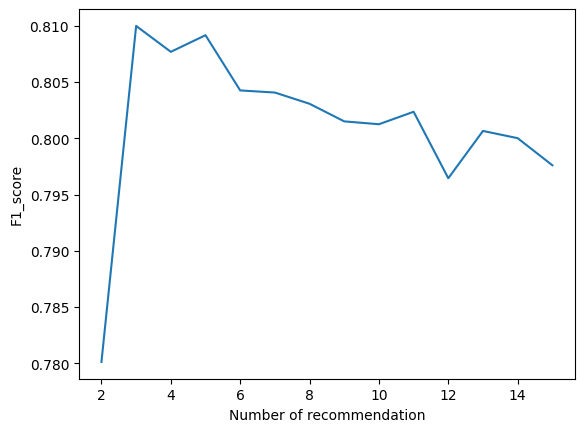

In [146]:
import matplotlib.pyplot as plt
plt.plot(k_array,f1_array)
plt.ylabel("F1_score")
plt.xlabel("Number of recommendation")

We observe that the F1_score is maximal with 5 books recommended and that it doesn' have a great variation as it's approximatively always 80%, so this parameter is not very important in our case. 5 is still a good value as we don't want to recommend to many books, a user usually consider only the first book recommended.

In [147]:
r_array,prec_array,recall_array,f1_array=[],[],[],[]
for r in np.arange(2,11):
    r_array.append(r)
    result=get_recall_precision_F1(5,r)
    prec_array.append(result[0])
    recall_array.append(result[1])
    f1_array.append(result[2])

Text(0.5, 0, 'Rating threshold')

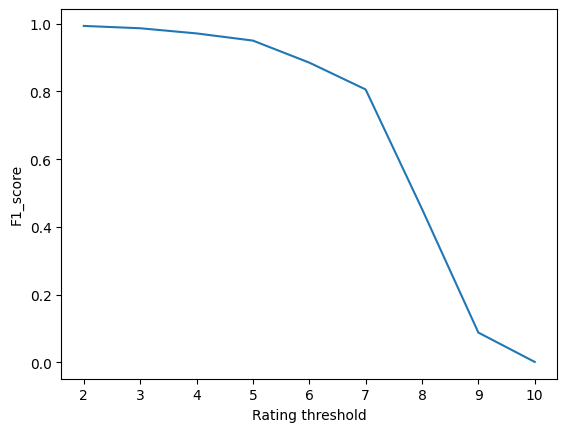

In [148]:
import matplotlib.pyplot as plt
plt.plot(r_array,f1_array)
plt.ylabel("F1_score")
plt.xlabel("Rating threshold")

We observe that the F1 score decrease with the increse of rating threshold wich is logical as more we are strict with the rating of the book to recommend more it'is difficult to respect the condition. The curve drop significantly after a threshold of 7. As book ratings of 5 and 6 are a little low to be recommended, We should use 7 as threshold.

In [50]:
print(get_recall_precision_F1(5,7))

(0.7987761587008405, 0.8182207676934137, 0.8083815511570662)


We get a precision of 80%, a recall of 82% and a F1 score of 80% which is average and coherent with the results obtained with the RMSE. This model is acceptable for our need but a better model can/should be found and it will be inacceptable in many field such as health.

In [1]:
#from neo4j import GraphDatabase
#driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "DSTI2023!!"))